# 2025 CITS4012 Project 2

## 1. Preprocessing

### 1.1. Import Libraries
Libraries are imported for the entire project.

*Note: Just add to this list as needed*

In [1]:
%pip install gensim
import gensim.downloader as api

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
import google.colab.drive as gc_drive
from pathlib import Path
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
import torch
import spacy
import re

torch.manual_seed(42)
random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 53.5 MB/s eta 0:00:00


### 1.2. Retrieve Data
First, we need to retrieve the train/val/test datafiles from the Google Drive.

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
train_fileid = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
val_fileid = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
test_fileid = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"

train_file = drive.CreateFile({'id': train_fileid})
val_file = drive.CreateFile({'id': val_fileid})
test_file = drive.CreateFile({'id': test_fileid})

train_file.GetContentFile('train.json')
val_file.GetContentFile('val.json')
test_file.GetContentFile('test.json')

In [4]:
# Mount your Drive
gc_drive.mount('/content/drive')

# Create only your experiment folders — dataset paths stay unchanged
PROJECT_DIR = Path("/content/drive/MyDrive/CITS4012_project")
CKPT_DIR = PROJECT_DIR / "checkpoints"
LOG_DIR = PROJECT_DIR / "logs"

for p in [CKPT_DIR, LOG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Checkpoints and logs will be saved here:")
print("Checkpoints:", CKPT_DIR)
print("Logs:", LOG_DIR)

Mounted at /content/drive
Checkpoints and logs will be saved here:
Checkpoints: /content/drive/MyDrive/CITS4012_project/checkpoints
Logs: /content/drive/MyDrive/CITS4012_project/logs


### 1.3. Read in the Data
We now read in each dataset, splitting the input data and target data. The data shapes and a sample of the training data are shown below.

In [5]:
train = pd.read_json('train.json')
X_train = train[['premise', 'hypothesis']]
y_train = train['label']

val = pd.read_json('val.json')
X_val = val[['premise', 'hypothesis']]
y_val = val['label']

test = pd.read_json('test.json')
X_test = test[['premise', 'hypothesis']]
y_test = test['label']

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
display(train)

Train shape: (23088, 2)
Val shape: (1304, 2)
Test shape: (2126, 2)


,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails
...,...,...,...
23083,"which is not only the motion of our bodies, bu...",Work is done only if a force is exerted in the...,neutral
23084,"The Red Star, that celestial curse whose eccen...",Red-shift refers to a shift toward red in the ...,neutral
23085,The lines in the spectrum of a luminous body s...,Red-shift refers to a shift toward red in the ...,entails
23086,The radial velocity of a star away from or tow...,Red-shift refers to a shift toward red in the ...,entails


#### 1.3.1 Label Mapping and Dicts
Convert each row to a dict and apply a fixed label map (entails: 1, neutral: 0) so downstream code gets consistent integer labels.

In [6]:

LABEL_MAP = {"entails": 1, "neutral": 0}

def df_to_examples(df):
    # Keep premise/hypothesis separate; attach deterministic int label y
    return [
        {
            "premise": row.premise,
            "hypothesis": row.hypothesis,
            "label": row.label,
            "y": LABEL_MAP[row.label],
        }
        for row in df.itertuples(index=False)
    ]

train_data = df_to_examples(train)
val_data = df_to_examples(val)
test_data = df_to_examples(test)

# quick sanity checkk
def describe(name, data):
    pos = sum(ex["y"] for ex in data)
    print(f"[{name}] #={len(data)}  entails(1)={pos}  neutral(0)={len(data)-pos}")

describe("train", train_data)
describe("val", val_data)
describe("test", test_data)


[train] #=23088  entails(1)=8470  neutral(0)=14618
[val] #=1304  entails(1)=657  neutral(0)=647
[test] #=2126  entails(1)=842  neutral(0)=1284


### 1.4. Data preprocessing
As seen above, the data contains characters that requires cleaning before passing it to the model.

The preprocessing pipeline is as follows:
- Sentences are tokenised using SpaCy.
- A vocabulary list is constructed, including a padding and out-of-vocabulary tag.
- A GloVe Embedding model is loaded, pretrained on twitter.
- Tokenised sentences are converted to an indexed list of words, padded to the maximum size of the premise and hypothesis, respectively.

The labels are also converted to 0 or 1 (0 = neutral, 1 = entails).

#### 1.4.1. SpaCy Tokenisation
We tokenise the premises and hypotheses for the training set - removing all non alphanumeric characters and converting words to lower case.

In [7]:
spacy.cli.download('en_core_web_sm')
tokeniser = spacy.load('en_core_web_sm')
premise_list = X_train['premise'].tolist()
hypothesis_list = X_train['hypothesis'].tolist()

prem_tokens_list = list(tokeniser.pipe(premise_list, batch_size=64))
X_train.loc[:, "premise"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in prem_tokens_list]

hyp_tokens_list = list(tokeniser.pipe(hypothesis_list, batch_size=64))
X_train.loc[:, "hypothesis"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in hyp_tokens_list]

display(X_train)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


KeyboardInterrupt: 

##### 1.4.1.1 Tokenisation for VSE
Deterministically tokenize premise and hypothesis separately (spaCy or lowercase-split) and attach the results as premise_tokens / hypo_tokens to each example. This keeps the raw DataFrame text intact for EDA, avoids concatenation (Siamese setup), applies the same tokenizer to all splits, and prepares for vocab building on the train split only.


In [8]:
import spacy, re
from spacy.cli import download as spacy_download

nlp = spacy.load("en_core_web_sm", disable=["ner","parser","tagger","lemmatizer"])

# ---- Token filtering toggles ----
# If you want to EXACTLY match your partner's behaviour (regex r'^\w+$', which allows underscores):
USE_PARTNER_REGEX = True

def keep_token_text(text: str) -> bool:
    if USE_PARTNER_REGEX:
        # Partner's rule: letters/digits/underscore only
        return bool(re.match(r'^\w+$', text))
    else:
        # Your previous rule: alphanumeric only (no underscores)
        return text.isalnum()

def tok_doc(doc):
    # lower-case + filter
    return [t.text.lower() for t in doc if keep_token_text(t.text)]

# ---------- DataFrame tokenisation (does NOT mutate raw text columns) ----------
def tokenize_dataset_df(df, dataset_name="dataset", batch_size=64):
    """
    Returns a copy with 'premise_tokens' and 'hypothesis_tokens' columns.
    Does not overwrite 'premise'/'hypothesis' raw text (handy for EDA).
    """
    print(f"Tokenising {dataset_name} (DataFrame view)...")
    out = df.copy()
    prem_docs = list(nlp.pipe(out["premise"].tolist(), batch_size=batch_size))
    hypo_docs = list(nlp.pipe(out["hypothesis"].tolist(), batch_size=batch_size))
    out["premise_tokens"] = [tok_doc(d) for d in prem_docs]
    out["hypothesis_tokens"] = [tok_doc(d) for d in hypo_docs]
    print(f"✓ {dataset_name} tokenised (added *_tokens columns)")
    return out

# ---------- Attach tokens into your examples list (used by your loaders) ----------
def attach_tokens_to_examples(df, examples, dataset_name="dataset", batch_size=64):
    """
    df: DataFrame with 'premise','hypothesis'
    examples: list of dicts with keys including 'premise','hypothesis','y'
    Side-effect: adds 'premise_tokens' and 'hypo_tokens' to each example (in place)
    """
    print(f"Attaching tokens to examples for {dataset_name}...")
    prem_docs = list(nlp.pipe(df['premise'].tolist(), batch_size=batch_size))
    hypo_docs = list(nlp.pipe(df['hypothesis'].tolist(), batch_size=batch_size))
    for ex, pdoc, hdoc in zip(examples, prem_docs, hypo_docs):
        ex['premise_tokens'] = tok_doc(pdoc)
        ex['hypo_tokens']   = tok_doc(hdoc)
    print(f"✓ Tokens attached for {dataset_name}")

# ----------------- Apply to train/val/test -----------------
# Assumes you already have:
#   train, val, test            -> DataFrames with 'premise','hypothesis'
#   train_data, val_data, ...   -> list[dict] examples consumed by your dataset/dataloader

attach_tokens_to_examples(train, train_data, dataset_name="Training set")
attach_tokens_to_examples(val,   val_data,   dataset_name="Validation set")
attach_tokens_to_examples(test,  test_data,  dataset_name="Test set")

# Optional: keep a tidy DataFrame view for quick EDA / sanity checks
X_train_tokens = tokenize_dataset_df(train, "Training set")
X_val_tokens   = tokenize_dataset_df(val,   "Validation set")
X_test_tokens  = tokenize_dataset_df(test,  "Test set")

# Peek
display(X_train_tokens.head())


Attaching tokens to examples for Training set...
✓ Tokens attached for Training set
Attaching tokens to examples for Validation set...
✓ Tokens attached for Validation set
Attaching tokens to examples for Test set...
✓ Tokens attached for Test set
Tokenising Training set (DataFrame view)...
✓ Training set tokenised (added *_tokens columns)
Tokenising Validation set (DataFrame view)...
✓ Validation set tokenised (added *_tokens columns)
Tokenising Test set (DataFrame view)...
✓ Test set tokenised (added *_tokens columns)


,premise,hypothesis,label,premise_tokens,hypothesis_tokens
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral,"[pluto, rotates, once, on, its, axis, every, e...","[earth, rotates, on, its, axis, once, times, i..."
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails,"[once, per, day, the, earth, rotates, about, i...","[earth, rotates, on, its, axis, once, times, i..."
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral,"[geysers, periodic, gush, of, hot, water, at, ...","[the, surface, of, the, sun, is, much, hotter,..."
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ..."
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i..."


##### Sanity Check

In [9]:
import numpy as np
from statistics import mean

# --- Sanity checks after tokenisation ---

def sanity_check_split(name, data_examples):
    """
    Verify tokenisation and label distribution for a given split.
    """
    # Check labels
    ys = [ex["y"] for ex in data_examples]
    label_counts = {0: ys.count(0), 1: ys.count(1)}

    # Check token lengths
    prem_lens = np.array([len(ex.get("premise_tokens", [])) for ex in data_examples])
    hypo_lens = np.array([len(ex.get("hypo_tokens", [])) for ex in data_examples])

    # Summary
    print(f"\n=== {name.upper()} SPLIT ===")
    print(f"Label counts: {label_counts}")
    print(f"Premise lens -> min:{prem_lens.min():>3}, mean:{mean(prem_lens):.1f}, max:{prem_lens.max():>3}")
    print(f"Hypoth  lens -> min:{hypo_lens.min():>3}, mean:{mean(hypo_lens):.1f}, max:{hypo_lens.max():>3}")
    print(f"Combined 99.5th percentile length: {np.percentile(np.r_[prem_lens, hypo_lens], 99.5):.1f}")
    print(f"Example token: {data_examples[0]['premise_tokens'][:8]} -> {len(data_examples[0]['premise_tokens'])} tokens")

# Run checks for all splits
sanity_check_split("train", train_data)
sanity_check_split("val", val_data)
sanity_check_split("test", test_data)



=== TRAIN SPLIT ===
Label counts: {0: 14618, 1: 8470}
Premise lens -> min:  0, mean:18.0, max:9966
Hypoth  lens -> min:  3, mean:11.0, max: 36
Combined 99.5th percentile length: 42.0
Example token: ['pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', 'earth'] -> 9 tokens

=== VAL SPLIT ===
Label counts: {0: 647, 1: 657}
Premise lens -> min:  2, mean:17.0, max: 52
Hypoth  lens -> min:  5, mean:12.0, max: 30
Combined 99.5th percentile length: 43.0
Example token: ['an', 'introduction', 'to', 'atoms', 'and', 'elements', 'compounds', 'atomic'] -> 16 tokens

=== TEST SPLIT ===
Label counts: {0: 1284, 1: 842}
Premise lens -> min:  2, mean:16.0, max: 46
Hypoth  lens -> min:  4, mean:12.0, max: 28
Combined 99.5th percentile length: 40.0
Example token: ['based', 'on', 'the', 'list', 'provided', 'of', 'the', 'uses'] -> 31 tokens


#### 1.4.2. Vocabulary Construction

In [ ]:
vocab_set = set([])
for tokens in X_train['premise']:
    for token in tokens:
        vocab_set.add(token)
for tokens in X_train['hypothesis']:
    for token in tokens:
        vocab_set.add(token)

# Convert the set to a list
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(vocab_set))

wordindexes = {word: i for i, word in enumerate(vocab)}

print(vocab[:50])

print(f"Vocabulary size: {len(vocab)}")


=== TRAIN SPLIT ===
Label counts: {0: 14618, 1: 8470}
Premise lens -> min:  0, mean:18.0, max:9966
Hypoth  lens -> min:  3, mean:11.0, max: 36
Combined 99.5th percentile length: 42.0
Example token: ['pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', 'earth'] -> 9 tokens

=== VAL SPLIT ===
Label counts: {0: 647, 1: 657}
Premise lens -> min:  2, mean:17.0, max: 52
Hypoth  lens -> min:  5, mean:12.0, max: 30
Combined 99.5th percentile length: 43.0
Example token: ['an', 'introduction', 'to', 'atoms', 'and', 'elements', 'compounds', 'atomic'] -> 16 tokens

=== TEST SPLIT ===
Label counts: {0: 1284, 1: 842}
Premise lens -> min:  2, mean:16.0, max: 46
Hypoth  lens -> min:  4, mean:12.0, max: 28
Combined 99.5th percentile length: 40.0
Example token: ['based', 'on', 'the', 'list', 'provided', 'of', 'the', 'uses'] -> 31 tokens


##### 1.4.2.1
Vocab Construction for the VSE model

In [9]:
# NEW:

from collections import Counter
from itertools import chain
import json
from pathlib import Path

# ---- Hyperparams (ideally these live in your Config dataclass) ----
MIN_FREQ   = 2               # prune rare tokens
MAX_VOCAB  = None            # e.g., set to 50_000 or leave None
SPECIALS   = ['[PAD]', '[OOV]']

# ---- 1) Count frequencies from TRAIN ONLY (premise + hypothesis) ----
counter = Counter()

# X_train_tokens has 'premise_tokens' and 'hypothesis_tokens' (lists of str)
counter.update(chain.from_iterable(X_train_tokens['premise_tokens']))
counter.update(chain.from_iterable(X_train_tokens['hypothesis_tokens']))

# Defensive: never keep specials if they somehow appear in data
for s in SPECIALS:
    if s in counter:
        del counter[s]

# ---- 2) Prune by min freq ----
items = [(tok, freq) for tok, freq in counter.items() if freq >= MIN_FREQ]

# ---- 3) Deterministic order: most frequent first, tie-break by token ----
items.sort(key=lambda x: (-x[1], x[0]))

# ---- 4) Optional cap on vocab size (after pruning & sorting) ----
if MAX_VOCAB is not None:
    items = items[:max(0, MAX_VOCAB - len(SPECIALS))]

# ---- 5) Build vocab & indexes ----
vocab = SPECIALS + [tok for tok, _ in items]
wordindexes = {w: i for i, w in enumerate(vocab)}  # PAD=0, OOV=1

print(f"Vocabulary size: {len(vocab)} (min_freq={MIN_FREQ}, max_vocab={MAX_VOCAB})")
print("Top-20 tokens:", vocab[len(SPECIALS):len(SPECIALS)+20])

assert wordindexes['[PAD]'] == 0 and wordindexes['[OOV]'] == 1

# ---- 6) Quick coverage / OOV diagnostics on each split ----
def oov_rate(tokens_series, word2idx):
    total = 0
    oov = 0
    for toks in tokens_series:
        total += len(toks)
        oov += sum(1 for t in toks if t not in word2idx)
    return (oov / max(total, 1), oov, total)

for name, df in [("train", X_train_tokens),
                 ("val",   X_val_tokens),
                 ("test",  X_test_tokens)]:
    r, oov, tot = oov_rate(df['premise_tokens'], wordindexes)
    r2, oov2, tot2 = oov_rate(df['hypothesis_tokens'], wordindexes)
    comb_r = (oov + oov2) / max(tot + tot2, 1)
    print(f"[{name}] OOV prem:{r:.3f} ({oov}/{tot})  hyp:{r2:.3f} ({oov2}/{tot2})  combined:{comb_r:.3f}")

# ---- 7) Persist vocab (reproducibility) ----
out_dir = Path("./artifacts")
out_dir.mkdir(parents=True, exist_ok=True)
with open(out_dir / "vocab.json", "w") as f:
    json.dump({"specials": SPECIALS, "min_freq": MIN_FREQ, "max_vocab": MAX_VOCAB, "vocab": vocab}, f, ensure_ascii=False, indent=2)
print("Saved vocab to artifacts/vocab.json")

# BEFORE UPDATES
# from collections import Counter

# # 1) count frequencies from TRAIN ONLY (premise + hypothesis)
# counter = Counter()
# for toks in X_train_tokens['premise_tokens']:
#   for token in toks:
#     #print(toks)
#     counter.update([token])

# for toks in X_train_tokens['hypothesis_tokens']:
#   for token in toks:
#     #print(toks)
#     counter.update([token])

# # 2) optional pruning
# MIN_FREQ = 2
# items = [(tok, freq) for tok, freq in counter.items() if freq >= MIN_FREQ]

# # 3) deterministic order: most frequent first, tie-break by token
# items.sort(key=lambda x: (-x[1], x[0]))

# # 4) build vocab with fixed specials
# vocab = ['[PAD]', '[OOV]'] + [tok for tok, _ in items]
# wordindexes = {w: i for i, w in enumerate(vocab)}  # PAD=0, OOV=1

# print("Vocabulary size:", len(vocab))
# print(vocab[:50])

# assert wordindexes['[PAD]'] == 0 and wordindexes['[OOV]'] == 1

Vocabulary size: 11236 (min_freq=2, max_vocab=None)
Top-20 tokens: ['the', 'of', 'a', 'is', 'and', 'in', 'to', 'are', 'that', 'an', 'as', 'for', 'by', 'or', 'water', 'from', 'energy', 'on', 'with', 'it']
[train] OOV prem:0.021 (8888/415920)  hyp:0.000 (3/270853)  combined:0.013
[val] OOV prem:0.039 (881/22524)  hyp:0.022 (359/16169)  combined:0.032
[test] OOV prem:0.040 (1441/35808)  hyp:0.016 (430/26405)  combined:0.030
Saved vocab to artifacts/vocab.json


#### 1.4.3 Embedding Table Creation
We load the GloVe embeddings, and then for each word in the training set vocabulary, we add the embedding to our lookup table. If a word in the vocabulary does not exist in the GloVe embeddings, it is embedded as zeros.

In [10]:
glove_embeddings = api.load("glove-twitter-100") #100 dimensional

emb_dim = glove_embeddings.vector_size

emb_table = []
for i, word in enumerate(vocab):
    if word in glove_embeddings:
        emb_table.append(glove_embeddings[word])
    else:
        emb_table.append(np.zeros(emb_dim))

emb_table = np.array(emb_table)

emb_table[wordindexes['[PAD]']] = np.zeros(emb_dim)
emb_table[wordindexes['[OOV]']] = np.random.normal(scale=0.6, size=(emb_dim,))

emb_table.shape

found = sum(1 for w in vocab if w in glove_embeddings)
coverage = found / len(vocab)
print(f"GloVe coverage: {found}/{len(vocab)} = {coverage:.2%}")

np.save("artifacts/embedding_table.npy", emb_table)
print("Saved embedding table to artifacts/embedding_table.npy")


# cleanup
del glove_embeddings



[==================================================] 100.0% 387.1/387.1MB downloaded
GloVe coverage: 9547/11236 = 84.97%
Saved embedding table to artifacts/embedding_table.npy


Later, we can now create an Embedding object that can be used to lookup the embeddings for any given word. This saves us from having to load the entire vocabulary embeddings at once during training.

### 1.5. Data visualisation
We will visualise the data to observe any patterns that we should be aware of before preprocessing and training.

First, lets observe the class balance for the train/val/test sets.

In [ ]:
print(
    "Training set distribution:\n"
    f"Neutral = {round(y_train[y_train == 'neutral'].shape[0] / y_train.shape[0],2)}\n"
    f"Entails = {round(y_train[y_train == 'entails'].shape[0] / y_train.shape[0],2)}\n"
    "Validation set distribution:\n"
    f"Neutral = {round(y_val[y_val == 'neutral'].shape[0] / y_val.shape[0],2)}\n"
    f"Entails = {round(y_val[y_val == 'entails'].shape[0] / y_val.shape[0],2)}\n"
    "Testing set distribution:\n"
    f"Neutral = {round(y_test[y_test == 'neutral'].shape[0] / y_test.shape[0],2)}\n"
    f"Entails = {round(y_test[y_test == 'entails'].shape[0] / y_test.shape[0],2)}\n"
)

Training set distribution:
Neutral = 0.63
Entails = 0.37
Validation set distribution:
Neutral = 0.5
Entails = 0.5
Testing set distribution:
Neutral = 0.6
Entails = 0.4



The training set is strongly skewed towards neutral samples - this will have an impact on training.

Now, we will observe the distribution of the token lengths of the premises and hypotheses of the train and validation sets.

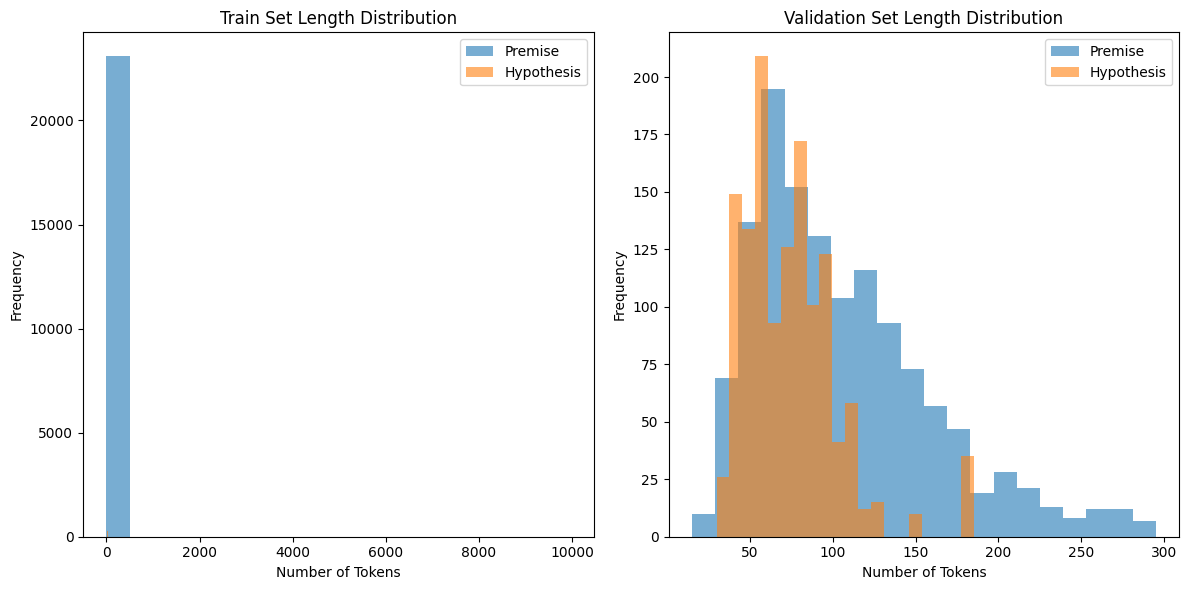

In [ ]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

val_prem_lengths = [len(premise) for premise in X_val['premise']]
val_hyp_lengths = [len(hypothesis) for hypothesis in X_val['hypothesis']]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

This indicates there are some outliers in the train set. Reviewing the ten largest premises in the training set reveals there are some abnormally large instances:

In [ ]:
largest_prem = sorted(range(len(train_prem_lengths)), key=lambda i: train_prem_lengths[i], reverse=True)[:10]
print([train_prem_lengths[i] for i in largest_prem])

[9966, 5829, 2249, 1154, 938, 705, 594, 550, 314, 111]


Removing these outliers from the training set, we get a nicer looking plot:

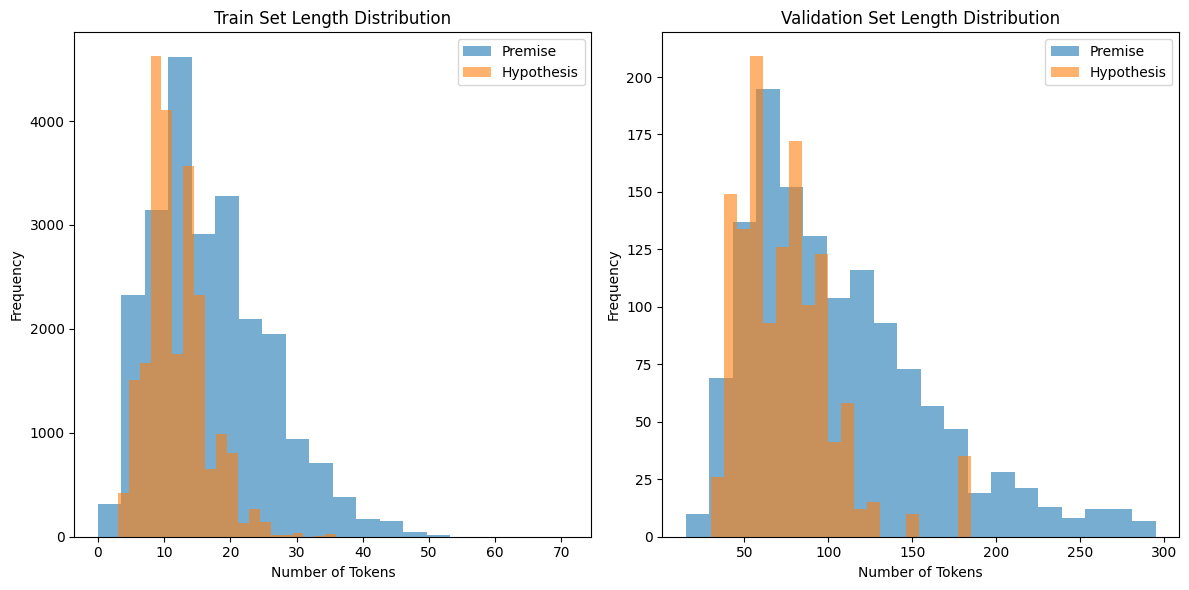

In [ ]:
X_train = X_train.drop(X_train.index[largest_prem])
y_train = y_train.drop(y_train.index[largest_prem])

train_prem_lengths = [len(premise) for premise in X_train['premise']]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

### 1.6. Dataset Formation
Now we create the training dataset. The tokenised premise and hypothesis sentences are encoded to be the index that corresponds to the word embedding in the embeddings table. Each sentence is then padded to be the same length as the longest respective premise or hypothesis.

In [ ]:
def encode_sentences(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append([wordindexes[word] if word in wordindexes else wordindexes['[OOV]'] for word in sentence])
    return encoded_sentences

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [wordindexes['[PAD]']] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences

max_prem = max(len(sentence) for sentence in X_train['premise'])
max_hyp = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_train = pad_sequences(encode_sentences(X_train['premise']), max_prem)
encoded_hyp_train = pad_sequences(encode_sentences(X_train['hypothesis']), max_hyp)

encoded_prem_val = pad_sequences(encode_sentences(X_val['premise']), max_prem)
encoded_hyp_val = pad_sequences(encode_sentences(X_val['hypothesis']), max_hyp)

The labels are now converted to 0 for neutral, and 1 for entails.

In [ ]:
y_train = y_train.map({'neutral': 0, 'entails': 1})
y_val = y_val.map({'neutral': 0, 'entails': 1})
y_test = y_test.map({'neutral': 0, 'entails': 1})

Now we can create the dataset and data loaders for the train and validation set. To reduce the impact of the class imbalance in the train set, the number of neutral samples is reduced to the number of entails samples.

In [ ]:
batch_size = 16

train_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_train), torch.tensor(encoded_hyp_train), torch.tensor(y_train.values))

neutral_indices = [i for i, label in enumerate(y_train.values) if label == 0]
entails_indices = [i for i, label in enumerate(y_train.values) if label == 1]

min_samplesize = min(len(neutral_indices), len(entails_indices))

# random sample from training set to make sure both are the same size
neutral_indices = random.sample(neutral_indices, min_samplesize)
entails_indices = random.sample(entails_indices, min_samplesize)

# combine the indices
train_indices = neutral_indices + entails_indices
random.shuffle(train_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

val_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_val), torch.tensor(encoded_hyp_val), torch.tensor(y_val.values))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

#### 1.6.1 Usage for VSE

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time

# ---------- Dataset ----------
class NLIPairDataset(torch.utils.data.Dataset):
    def __init__(self, premises_tok, hypos_tok, labels, wordindexes):
        self.premises_tok = premises_tok   # list[list[str]]
        self.hypos_tok = hypos_tok
        self.labels = labels               # list[int] 0/1
        self.wordindexes = wordindexes

    def __len__(self):
        return len(self.labels)

    def encode(self, toks):
        # map tokens to ids; OOV if missing
        return [self.wordindexes.get(w, self.wordindexes['[OOV]']) for w in toks]

    def __getitem__(self, i):
        p_ids = torch.tensor(self.encode(self.premises_tok[i]), dtype=torch.long)
        h_ids = torch.tensor(self.encode(self.hypos_tok[i]),    dtype=torch.long)
        y     = torch.tensor(int(self.labels[i]), dtype=torch.long)
        return {"premise_ids": p_ids, "hypo_ids": h_ids, "labels": y}

# ---------- Collate (robust to empty sequences) ----------
def collate_bilstm(batch, max_len=128, pad_id=0):

    def pad_with_lengths(seqs, pad_id=0):
        # Ensure each sequence has at least length 1 (PAD) to avoid zero-length errors
        safe_seqs = [s if len(s) > 0 else torch.tensor([pad_id], dtype=torch.long) for s in seqs]
        lens = torch.tensor([len(s) for s in safe_seqs], dtype=torch.long)
        L = max(1, min(int(lens.max().item()), int(max_len)))
        out = torch.full((len(safe_seqs), L), pad_id, dtype=torch.long)
        for i, s in enumerate(safe_seqs):
            s = s[:L]
            out[i, :len(s)] = s
        # clamp any length > L and guarantee min 1
        lens = lens.clamp(min=1, max=L)
        return out, lens

    p_ids_list = [item["premise_ids"] for item in batch]
    h_ids_list = [item["hypo_ids"]   for item in batch]
    y_list     = [item["labels"]     for item in batch]

    p_pad, p_len = pad_with_lengths(p_ids_list, pad_id=pad_id)
    h_pad, h_len = pad_with_lengths(h_ids_list, pad_id=pad_id)
    y = torch.stack(y_list)

    return {
        "premise_ids": p_pad,
        "premise_lengths": p_len,
        "hypo_ids": h_pad,
        "hypo_lengths": h_len,
        "labels": y,
    }

# ---------- Build datasets ----------
train_ds = NLIPairDataset(
    premises_tok=X_train_tokens['premise_tokens'].tolist(),
    hypos_tok=X_train_tokens['hypothesis_tokens'].tolist(),
    labels=[LABEL_MAP[l] for l in y_train],
    wordindexes=wordindexes
)
val_ds = NLIPairDataset(
    premises_tok=X_val_tokens['premise_tokens'].tolist(),
    hypos_tok=X_val_tokens['hypothesis_tokens'].tolist(),
    labels=[LABEL_MAP[l] for l in y_val],
    wordindexes=wordindexes
)
test_ds = NLIPairDataset(
    premises_tok=X_test_tokens['premise_tokens'].tolist(),
    hypos_tok=X_test_tokens['hypothesis_tokens'].tolist(),
    labels=[LABEL_MAP[l] for l in y_test],
    wordindexes=wordindexes
)


# Keep class balancing indices, but feed them to DataLoader via sampler
neutral_indices = [i for i, label in enumerate(train_ds.labels) if label == 0]
entails_indices = [i for i, label in enumerate(train_ds.labels) if label == 1]

min_samplesize = min(len(neutral_indices), len(entails_indices))

# random sample from training set to make sure both are the same size
neutral_indices = random.sample(neutral_indices, min_samplesize)
entails_indices = random.sample(entails_indices, min_samplesize)

# combine the indices
train_indices = neutral_indices + entails_indices
random.shuffle(train_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)


# Compute MAX_LEN from datasets (not from train_data)
prem_lens = np.array([len(toks) for toks in train_ds.premises_tok], dtype=np.int32)
hypo_lens = np.array([len(toks) for toks in train_ds.hypos_tok],   dtype=np.int32)
all_lens  = np.concatenate([prem_lens, hypo_lens])


# OLD
# # Need to re-calculate these based on the datasets, not the original X_train/train_data
# prem_lens = np.array([len(ex["premise_tokens"]) for ex in train_data]) # This still seems wrong, should be from train_ds
# hypo_lens = np.array([len(ex["hypo_tokens"]) for ex in train_data]) # This still seems wrong, should be from train_ds
# all_lens  = np.concatenate([prem_lens, hypo_lens])

p = 99.5  # value between ~95-99 (.5% is a massive outlier)
suggested = int(np.percentile(all_lens, p)) if all_lens.size else 32
MAX_LEN = max(1, min(suggested, 256))  # ensure >= 1

trunc_frac = (all_lens > MAX_LEN).mean()
print(f"MAX_LEN set to {MAX_LEN} (truncates ~{trunc_frac*100:.1f}% tokens)")


# Dataloaders:

batch_size = 64
pad_id = wordindexes['[PAD]']

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size,
    sampler=train_sampler,   # enable if you want class balancing
    shuffle=False,             # use shuffle if sampler is disabled
    collate_fn=lambda b: collate_bilstm(b, max_len=MAX_LEN, pad_id=pad_id)
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    collate_fn=lambda b: collate_bilstm(b, max_len=MAX_LEN, pad_id=pad_id)
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    collate_fn=lambda b: collate_bilstm(b, max_len=MAX_LEN, pad_id=pad_id)
)

# Class weights for cross-entropy
# Collect train labels once from the dataset (faster & cleaner than looping the loader)
labels_train = [int(train_ds[i]["labels"]) for i in range(len(train_ds))]

counts = np.bincount(labels_train, minlength=2)
freq = counts / counts.sum()
w = 1.0 / (freq + 1e-8)
w = w / w.sum() * 2.0
print("Class weights (0,1):", w.tolist(), " | counts:", counts.tolist())

# Save w in a variable; later (after model creation) do:
# class_weights = torch.tensor(w, dtype=torch.float32, device=CFG.device)
# model.class_weights = class_weights

MAX_LEN set to 42 (truncates ~0.5% tokens)
Class weights (0,1): [0.7337144890401939, 1.2662855109598061]  | counts: [14618, 8470]


### 1.7 Test Dataset
Finally, we create the test dataset in a similar way the training and validation sets are created.

In [16]:
max_prem = max(len(sentence) for sentence in X_test['premise'])
max_hyp = max(len(sentence) for sentence in X_test['hypothesis'])
encoded_prem_test = pad_sequences(encode_sentences(X_test['premise']), max_prem)
encoded_hyp_test = pad_sequences(encode_sentences(X_test['hypothesis']), max_hyp)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_test), torch.tensor(encoded_hyp_test), torch.tensor(y_test.values))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

NameError: name 'pad_sequences' is not defined

In [ ]:
# Dataloader sample usage
# for i, batch in enumerate(train_loader):
    # i = batch number
    # premises   = batch[0]
    # hypotheses = batch[1]
    # labels     = batch[2]

#### 1.7.1 For VSE
(padding handled in collate_bilstm)

In [12]:
# get one batch
batch = next(iter(train_loader))

# expect these keys
print("keys:", list(batch.keys()))
assert "premise_ids" in batch and "hypo_ids" in batch
assert "premise_lengths" in batch and "hypo_lengths" in batch
assert "labels" in batch

# shapes
print("premise_ids shape:", batch["premise_ids"].shape)
print("hypo_ids shape:   ", batch["hypo_ids"].shape)
print("premise_len shape:", batch["premise_lengths"].shape)
print("hypo_len shape:   ", batch["hypo_lengths"].shape)
print("labels shape:     ", batch["labels"].shape)

# peek at first example
i = 0
p_len = int(batch["premise_lengths"][i])
h_len = int(batch["hypo_lengths"][i])
print(f"\nexample {i}: p_len={p_len}, h_len={h_len}, label={int(batch['labels'][i])}")

# show first few ids (should be non-zero up to length, then zeros)
print("premise_ids[:15]:", batch["premise_ids"][i, :15].tolist())
print("hypo_ids[:15]:   ", batch["hypo_ids"][i, :15].tolist())

# quick sanity: pads should be 0 and only after length
pad_id = 0
prem_ids = batch["premise_ids"][i].tolist()
hypo_ids  = batch["hypo_ids"][i].tolist()

assert all(x != pad_id for x in prem_ids[:p_len]), "pad inside premise actual tokens?"
assert all(x == pad_id for x in prem_ids[p_len:]), "no padding after premise length?"

assert all(x != pad_id for x in hypo_ids[:h_len]), "pad inside hypo actual tokens?"
assert all(x == pad_id for x in hypo_ids[h_len:]), "no padding after hypo length?"


keys: ['premise_ids', 'premise_lengths', 'hypo_ids', 'hypo_lengths', 'labels']
premise_ids shape: torch.Size([64, 42])
hypo_ids shape:    torch.Size([64, 23])
premise_len shape: torch.Size([64])
hypo_len shape:    torch.Size([64])
labels shape:      torch.Size([64])

example 0: p_len=12, h_len=12, label=0
premise_ids[:15]: [2, 79, 5, 358, 3, 1452, 151, 25, 168, 190, 6, 74, 0, 0, 0]
hypo_ids[:15]:    [2, 90, 3, 190, 22, 1781, 72, 59, 3, 2, 111, 139, 0, 0, 0]


##### Saanity Check

In [13]:
# dataloader check
batch = next(iter(train_loader))
print("keys:", list(batch.keys()))
print({k:v.shape for k,v in batch.items() if k!='labels'}, "labels:", batch["labels"].shape)

i = 0
p_len = int(batch["premise_lengths"][i]); h_len = int(batch["hypo_lengths"][i])
pad_id = 0
prem_ids = batch["premise_ids"][i].tolist()
hypo_ids = batch["hypo_ids"][i].tolist()

assert all(x != pad_id for x in prem_ids[:p_len]) and all(x == pad_id for x in prem_ids[p_len:])
assert all(x != pad_id for x in hypo_ids[:h_len]) and all(x == pad_id for x in hypo_ids[h_len:])
print("batch looks sane")

keys: ['premise_ids', 'premise_lengths', 'hypo_ids', 'hypo_lengths', 'labels']
{'premise_ids': torch.Size([64, 41]), 'premise_lengths': torch.Size([64]), 'hypo_ids': torch.Size([64, 31]), 'hypo_lengths': torch.Size([64])} labels: torch.Size([64])
batch looks sane


# 2. Variational Siamese Encoder Model

This section implements the Variational Siamese Encoder for NLI. Each sentence is encoded by a BiLSTM into a latent distribution (μ, logσ²). A latent vector z is sampled using the reparameterization trick. The premise and hypothesis encodings are then combined and passed through an MLP classifier. Training uses cross-entropy plus KL divergence to regularize the latent space.


## 2.1 Config
configuring hyperparameters and the device

In [13]:
from dataclasses import dataclass, asdict
import torch, time

def default_run_name(prefix="run"):
    ts = time.strftime("%Y%m%d-%H%M%S")
    return f"{prefix}_{ts}"

@dataclass
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # --- tokenisation ---
    spacy_model: str = "en_core_web_sm"
    spacy_disable: tuple = ("ner","parser","tagger","lemmatizer")
    use_partner_regex: bool = True              # True => r'^\w+$', False => str.isalnum()
    token_filter_regex: str = r"^\w+$"          # can loosen to r"^[\w\-']+$" if needed

    # --- vocab / artefacts ---
    artifacts_dir: str = "artifacts"
    min_freq: int = 2
    max_vocab: int | None = None                # cap if you add BoW decoder
    pad_token: str = "[PAD]"
    oov_token: str = "[OOV]"

    # encoder
    embedding_dim: int = 100
    lstm_hidden: int = 300  # risen from 256
    lstm_layers: int = 1
    bidir: bool = True
    dropout: float = 0.1

    # --- embeddings (new) ---
    glove_source: str = "glove-twitter-100"     # keep current; switch to 'glove-wiki-gigaword-100' if desired
    set_oov_random: bool = True                 # randomise OOV row instead of zeros
    freeze_embeddings: bool = False

    #variational
    latent_dim: int = 128  # risen from 64
    beta: float = 0.004    # your current global beta
    kl_anneal_steps: int = 0        # 0 = off; otherwise linear warm-up steps
    beta_max: float = 0.004          # (new) final beta target; matches beta by default

    # classifier
    mlp_hidden: int = 256  # risen from 128

    # --- training / data (minor adds) ---
    lr: float = 2e-4
    weight_decay: float = 0.01
    epochs: int = 10
    batch_size: int = 64                    # (new) used by DataLoader
    balance_classes: bool = False           # (new) if True, use your SubsetRandomSampler

    # --- seq length heuristic (new, matches your code) ---
    max_len_percentile: float = 99.5
    max_len_cap: int = 256

    # --- threshold/calibration (optional, new) ---
    tune_threshold_on_val: bool = True
    temperature_scale: bool = False

    # --- decoder hook (future-proof, stays inactive) ---
    recon: str = "feat"                     # {"none","bow","feat"}
    gamma: float = 0.3

    #ablation toggles (kept commented in spirit)
    run_name: str = default_run_name("baseline")  # used for plots/logging

CFG = Config()
CFG.num_classes = 2
print("Run:", CFG.run_name)


Run: baseline_20251019-005519


## 2.2 Encoder (BiLSTM) + pooling

In [14]:
import torch.nn as nn

# Mean-pooling layer that ignores padding tokens via a mask
class MaskedMeanPool(nn.Module):
    def forward(self, x, mask):
        # x: [B,L,H], mask: [B,L] (1=real, 0=pad)
        mask = mask.float().unsqueeze(-1)
        x = x * mask #zero-out pads
        denom = mask.sum(dim=1).clamp_min(1e-6) #avoid zero-division
        return x.sum(dim=1) / denom #mean of reaal tokens

# BiLSTM sentence encoder with masked mean pooling over token states
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=200, hidden=256, layers=1, bidir=True, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)  # PAD=0
        self.lstm = nn.LSTM(
            input_size = emb_dim,
            hidden_size = hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=dropout if layers > 1 else 0.0 #dropout only if layers > 1
        )

        self.out_dim = hidden * (2 if bidir else 1)
        self.mean_pool = MaskedMeanPool()  # expects (seq, mask) -> [B,D]

        # attention modules (single-head) for encoder-side pooling
        # self.enc_additive = AdditiveAttention(out_dim)
        # self.enc_scaled = ScaledDotAttention(out_dim)

    def forward(self, ids, lengths):
        # ids: [B,L], lengths: [B]
        emb = self.embed(ids)  # [B,L,E]
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        seq, _ = self.lstm(packed)
        seq, _ = nn.utils.rnn.pad_packed_sequence(seq, batch_first=True, total_length=ids.size(1))  # [B,L,D]
        mask = (ids != 0).long()  # [B,L], 1 for real tokens
        s = self.mean_pool(seq, mask)  # [B,D]
        return s


## Attention Modules (DONT USE)


In [ ]:
# EMPTY

## 2.3 VSE Model
variational heads + comparator + classifier

In [15]:
# OLD VERSION BFORE ABLATION

import torch.nn.functional as F
import torch
import torch.nn as nn

# Variational Siamese NLI model: encodes both sentences, reparameterizes z, then classifies their relation
class VariationalSiameseEncoder(nn.Module):
    def __init__(self, encoder, H, D, mlp_hidden=128, dropout=0.1, recon="none", gamma=0.0):
        super().__init__()
        self.encoder = encoder           # shared sentence encoder
        self.mu = nn.Linear(H, D)       # mean head over sentence rep s
        self.logvar = nn.Linear(H, D)   # log-variance head over s
        self.classifier = nn.Sequential(
            nn.Linear(2*D + 2*H, CFG.mlp_hidden),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(CFG.mlp_hidden, 2)
        )
        self.recon = recon
        self.gamma = gamma
        if self.recon == "feat":
            emb_dim = self.encoder.embed.embedding_dim  # uses your embedding table dim
            self.rec_head = nn.Sequential(
                nn.Linear(D, H), nn.ReLU(),
                nn.Linear(H, emb_dim)
            )
        else:
            self.rec_head = None

    def _encode(self, s):
        return self.mu(s), self.logvar(s)

    def _reparam(self, mu, logv, use_mu_inference=False):
        if use_mu_inference:    # deterministic path at eval
            return mu
        std = (0.5 * logv).exp()
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, batch, beta=0.01, use_mu_inference=False):
        # encode premise and hypothesis -> sentence reps s1, s2
        s1 = self.encoder(batch["premise_ids"], batch["premise_lengths"])
        s2 = self.encoder(batch["hypo_ids"], batch["hypo_lengths"])

        # VAE heads + reparameterization for each side
        mu1, logv1 = self._encode(s1)
        mu2, logv2 = self._encode(s2)
        z1 = self._reparam(mu1, logv1, use_mu_inference)
        z2 = self._reparam(mu2, logv2, use_mu_inference)


        # pair features: |z1−z2|, z1·z2 plus raw s1,s2 (helps classifier)
        feat = torch.cat([torch.abs(z1 - z2), z1 * z2, s1, s2], dim=-1)
        logits = self.classifier(feat)

        if "labels" not in batch:
            return {"logits": logits}

        labels = batch["labels"]

        ce = F.cross_entropy(logits, labels, weight=getattr(self, "class_weights", None)) #OLD: ce  = F.cross_entropy(logits, labels)  # task loss
        # KL for each side (diag Gaussian vs. N(0, I))
        kl1 = 0.5 * torch.sum(torch.exp(logv1) + mu1**2 - 1. - logv1, dim=1).mean()
        kl2 = 0.5 * torch.sum(torch.exp(logv2) + mu2**2 - 1. - logv2, dim=1).mean()
        kl  = kl1 + kl2

        # feature reconstruction loss (hypothesis side)
        rec = torch.tensor(0.0, device=logits.device)
        if self.recon == "feat" and self.rec_head is not None and self.gamma > 0.0:
            # masked mean of hypothesis *embeddings* (no grad)
            with torch.no_grad():
                emb = self.encoder.embed(batch["hypo_ids"])           # [B, L, E]
                mask = (batch["hypo_ids"] != 0).float().unsqueeze(-1) # PAD=0
                emb_masked = emb * mask
                denom = mask.sum(dim=1).clamp_min(1e-6)
                h_bow = emb_masked.sum(dim=1) / denom                 # [B, E]
            # predict it from z2
            h_hat = self.rec_head(z2)                                  # [B, E]
            rec = F.mse_loss(h_hat, h_bow)

        loss = ce + beta * kl + self.gamma * rec

        return {"logits": logits, "loss_total": loss, "loss_task": ce, "loss_kl": kl, "loss_rec": rec}


## 2.4 Build the Model

In [16]:
# Build VSE-BiLSTM model and load pre-trained GloVe embeddings
vocab_size = len(wordindexes) if isinstance(wordindexes, dict) else len(vocab)  # adapt to vocab container
H = CFG.lstm_hidden * (2 if CFG.bidir else 1)         # BiLSTM doubles hidden size if bidirectional

encoder = BiLSTMEncoder(
    vocab_size=vocab_size,
    emb_dim=CFG.embedding_dim,     #must match emb_table dim (100 for glove-twitter-100)
    hidden=CFG.lstm_hidden,
    layers=CFG.lstm_layers,
    bidir=CFG.bidir,
    dropout=CFG.dropout
)

model = VariationalSiameseEncoder(
    encoder=encoder,
    H=H,
    D=CFG.latent_dim,     # latent z dim for each side
    mlp_hidden=CFG.mlp_hidden,
    dropout=CFG.dropout,
    recon=CFG.recon,
    gamma=CFG.gamma
).to(CFG.device)

#load pre-trained GloVe into the embedding layer (ensure shapes match)
assert model.encoder.embed.weight.data.shape == torch.Size(emb_table.shape), \
    f"Embedding shape mismatch: layer {tuple(model.encoder.embed.weight.shape)} vs table {emb_table.shape}"

with torch.no_grad():
    model.encoder.embed.weight.data.copy_(torch.tensor(emb_table, dtype=torch.float32))  #init from GloVe


sum_params = sum(p.numel() for p in model.parameters())/1e6

print("Recon on?", CFG.recon, "| gamma:", CFG.gamma,"| emb_dim:", model.encoder.embed.embedding_dim)

print(f"Model ready. Params: {sum_params:.2f}M  |  H={H}, D={CFG.latent_dim}")


Recon on? feat | gamma: 0.3 | emb_dim: 100
Model ready. Params: 2.75M  |  H=600, D=128


##### Sanity Check

In [25]:
# tiny-batch overfit (run once for debugging)
tiny = next(iter(train_loader))
tiny = {k: v.to(CFG.device) for k,v in tiny.items()}

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)

model.train() # Set model to training mode before the loop
for _ in range(200):
    out = model(tiny, beta=0.0, use_mu_inference=False)  # no KL
    opt.zero_grad()
    out["loss_task"].backward()
    opt.step()

model.eval() # Set model back to evaluation mode after the loop
with torch.no_grad():
    preds = model(tiny, beta=0.0, use_mu_inference=True)["logits"].argmax(-1)
    print("tiny overfit acc:", (preds == tiny["labels"]).float().mean().item())

tiny overfit acc: 1.0


## 2.5 Train/Val Loops
\+ best checkpoint

In [26]:
import time
import csv, math, pathlib, time
import torch
from torch import nn, optim

# Training + evaluation loops with β warm-up, grad clipping, and best-checkpoint saving

def evaluate(model, loader, use_mu_inference=True):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(CFG.device) for k, v in batch.items()}
            out = model(batch, beta=CFG.beta, use_mu_inference=use_mu_inference)  # deterministic path at eval
            preds = out["logits"].argmax(-1)
            labels = batch["labels"]
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / max(total, 1)

# per-run Drive paths + CSV header (uses LOG_DIR / CKPT_DIR / CFG.run_name)
run_dir = (LOG_DIR / CFG.run_name)
run_dir.mkdir(parents=True, exist_ok=True)
log_path = run_dir / "metrics.csv"
best_path = CKPT_DIR / f"best_{CFG.run_name}.pt"

with open(log_path, "w", newline="") as f:
    csv.writer(f).writerow(["epoch","train_loss","train_task","train_kl","train_rec","val_acc"])

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay) # WD on by default

best_val = -1.0
# best_path = "best_vse_bilstm.pt"

for epoch in range(1, CFG.epochs+1):
    model.train()
    t0 = time.time()
    seen = 0
    loss_sum = task_sum = kl_sum = rec_sum = 0.0

    for batch in train_loader:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}

        warmup_epochs = max(1, int(0.3 * CFG.epochs)) # 30% of training
        beta_t = CFG.beta * min(1.0, epoch / warmup_epochs)  # linear warm-up over number of epochs

        out = model(batch, beta=beta_t, use_mu_inference=False)  # stochastic z during training   ---   #previous: out = model(batch, beta=CFG.beta, use_mu_inference=False)
        rec_val = out.get("loss_rec", torch.tensor(0.0, device=CFG.device))
        loss = out["loss_total"]
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip to stabilise LSTM
        optimizer.step()

        bs = batch["labels"].size(0)
        seen += bs
        loss_sum += out["loss_total"].item() * bs
        task_sum += out["loss_task"].item() * bs
        kl_sum += out["loss_kl"].item() * bs
        rec_sum += rec_val.item() * bs

    train_loss = loss_sum / max(1, seen)
    train_task = task_sum / max(1, seen)
    train_kl = kl_sum / max(1, seen)
    train_rec  = rec_sum  / max(1, seen)

    val_acc = evaluate(model, val_loader, use_mu_inference=True)
    print(f"Epoch {epoch:02d} | {time.time()-t0:.1f}s | loss={train_loss:.4f} (task={train_task:.4f}, kl={train_kl:.4f}) | rec={train_rec:.4f} | val_acc={val_acc:.4f}")

    # quick diagnostic: average logits on val to spot class bias
    with torch.no_grad():
        s = torch.zeros(2, device=CFG.device); n=0
        for b in val_loader:
            b = {k:v.to(CFG.device) for k,v in b.items()}
            lg = model(b, beta=0.0, use_mu_inference=True)["logits"]
            s += lg.mean(0); n += 1
        print("avg val logits:", (s/n).tolist())

    #append metrics row to CSV in Drive
    with open(log_path, "a", newline="") as f:
        csv.writer(f).writerow([epoch, train_loss, train_task, train_kl,train_rec, val_acc])


    if val_acc > best_val:     # save best-by-val-acc checkpoint
        best_val = val_acc
        torch.save({"state": model.state_dict(), "cfg": asdict(CFG)}, best_path)
        print("  saved best ->", best_path)

print("Best val acc:", best_val)
print("Run log CSV:", log_path)
print("Best checkpoint:", best_path)


Epoch 01 | 7.5s | loss=0.7696 (task=0.7468, kl=4.1379) | rec=0.0575 | val_acc=0.6840
avg val logits: [-0.3065932095050812, 0.13295242190361023]
  saved best -> /content/drive/MyDrive/CITS4012_project/checkpoints/best_baseline_20251018-135344.pt
Epoch 02 | 7.9s | loss=0.5354 (task=0.5237, kl=0.5447) | rec=0.0341 | val_acc=0.7140
avg val logits: [-0.43240755796432495, 0.2623317241668701]
  saved best -> /content/drive/MyDrive/CITS4012_project/checkpoints/best_baseline_20251018-135344.pt
Epoch 03 | 6.9s | loss=0.4643 (task=0.4532, kl=0.3447) | rec=0.0324 | val_acc=0.7155
avg val logits: [-0.47933024168014526, 0.27674493193626404]
  saved best -> /content/drive/MyDrive/CITS4012_project/checkpoints/best_baseline_20251018-135344.pt
Epoch 04 | 8.1s | loss=0.4075 (task=0.3970, kl=0.2603) | rec=0.0314 | val_acc=0.6986
avg val logits: [-0.694449782371521, 0.42560356855392456]
Epoch 05 | 6.9s | loss=0.3687 (task=0.3586, kl=0.2288) | rec=0.0307 | val_acc=0.7186
avg val logits: [-0.5784201622009277

## 2.6 Final Test Evaluation
and confusion matrix

Loaded /content/drive/MyDrive/CITS4012_project/checkpoints/best_baseline_20251018-135344.pt
Test accuracy: 0.6806
Confusion matrix (rows=true, cols=pred):
 [[814 470]
 [209 633]]
              precision    recall  f1-score   support

 neutral (0)      0.796     0.634     0.706      1284
 entails (1)      0.574     0.752     0.651       842

    accuracy                          0.681      2126
   macro avg      0.685     0.693     0.678      2126
weighted avg      0.708     0.681     0.684      2126



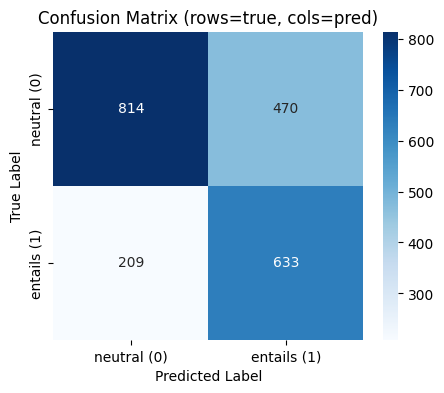

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# load best
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=CFG.device)
    model.load_state_dict(ckpt["state"])
    print("Loaded", best_path)

# evaluate with deterministic inference (use μ)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        out = model(batch, beta=CFG.beta, use_mu_inference=True)
        preds = out["logits"].argmax(-1).cpu().numpy()
        labs  = batch["labels"].cpu().numpy()
        all_preds.append(preds); all_labels.append(labs)

preds = np.concatenate(all_preds) if all_preds else np.array([])
labs  = np.concatenate(all_labels) if all_labels else np.array([])
acc = (preds == labs).mean() if preds.size else 0.0

cm = np.zeros((2,2), dtype=int)
for t,p in zip(labs, preds): cm[t,p] += 1

print(f"Test accuracy: {acc:.4f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)
report = classification_report(labs, preds, target_names=["neutral (0)", "entails (1)"], digits=3)
print(report)

labels = ["neutral (0)", "entails (1)"]
cm = confusion_matrix(labs, preds, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (rows=true, cols=pred)")
plt.show()

# 3. Additional Ablation Study


3.1. Utilities and Builder

In [17]:
# === Ablation Study Utilities (metrics, run id, builder) ===
import csv, time, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from dataclasses import asdict
from pathlib import Path
from functools import partial
import torch

# ---------- Metrics ----------
def compute_metrics(model, loader, device=None, use_mu_inference=True, beta_for_eval=None, num_classes=2):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device or CFG.device) for k, v in batch.items()}
            out = model(batch, beta=(beta_for_eval if beta_for_eval is not None else getattr(CFG,"beta",1.0)),
                        use_mu_inference=use_mu_inference)
            preds.append(out["logits"].argmax(-1).cpu().numpy())
            labels.append(batch["labels"].cpu().numpy())
    y_pred, y_true = np.concatenate(preds), np.concatenate(labels)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=list(range(num_classes)), zero_division=0)
    return {"accuracy": float(acc), "macro_f1": float(f1.mean() if len(f1) else 0.0),
            "per_class_f1": [float(x) for x in f1], "support": [int(x) for x in support]}

def timestamp():
    return time.strftime("%Y%m%d_%H%M%S")

def run_id_from_cfg(tag="gamma"):
    parts = [str(tag), f"ep{getattr(CFG,'epochs',10)}", f"bs{getattr(CFG,'batch_size',64)}",
             f"lr{getattr(CFG,'lr',1e-3)}", timestamp()]
    return "_".join(parts)

# ---------- Model + Dataloaders Builder (no scheduler) ----------
def build_vsae_from_cfg():
    """
    Builds model + optimizer + loaders for a fresh run.
    Uses globals from earlier cells: encoder, H, train_ds, val_ds, test_ds, collate_bilstm, pad_id, MAX_LEN,
    and optional train_sampler.
    """
    model = VariationalSiameseEncoder(
        encoder=encoder,
        H=H,
        D=CFG.latent_dim,
        mlp_hidden=CFG.mlp_hidden,
        dropout=CFG.dropout,
        recon=CFG.recon,
        gamma=CFG.gamma
    ).to(CFG.device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=getattr(CFG, "lr", 1e-3),
                                  weight_decay=getattr(CFG, "weight_decay", 0.0))

    # Collate + loaders
    _max_len = getattr(CFG, "max_len", MAX_LEN)
    _pad_id  = getattr(CFG, "pad_id", pad_id)
    collate  = partial(collate_bilstm, max_len=_max_len, pad_id=_pad_id)

    sampler = train_sampler if "train_sampler" in globals() and train_sampler is not None else None
    shuffle_flag = (sampler is None)

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=getattr(CFG, "batch_size", 64),
        sampler=sampler,
        shuffle=shuffle_flag,
        collate_fn=collate,
        drop_last=True
    )

    eval_bs = getattr(CFG, "eval_batch_size", getattr(CFG, "batch_size", 64))
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False, collate_fn=collate)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=eval_bs, shuffle=False, collate_fn=collate)

    scheduler = None
    return model, train_loader, val_loader, test_loader, optimizer, scheduler


#### 3.2. Training Wrapper

In [18]:
def train_full_run_and_return_paths(run_name: str):
    """
    Integrated version of your training loop:
    - β warm-up
    - grad clipping
    - CSV logging
    - best-by-val-acc checkpointing
    Expects globals from build_vsae_from_cfg(): model, train_loader, val_loader, test_loader, optimizer, scheduler(None)
    """
    # ---- per-run output paths ----
    out_dir = Path("runs") / run_name
    out_dir.mkdir(parents=True, exist_ok=True)
    log_path  = out_dir / "train_log.csv"
    best_path = out_dir / "best.pt"

    # ---- header for CSV log ----
    with open(log_path, "w", newline="") as f:
        csv.writer(f).writerow(["epoch", "train_loss", "train_task", "train_kl", "train_rec", "val_acc"])

    best_val = -1.0

    # ---------- TRAIN + EVAL LOOP ----------
    E = getattr(CFG, "epochs", 10)
    base_beta = float(getattr(CFG, "beta", 1.0))
    warmup_E  = int(getattr(CFG, "beta_warmup_epochs", 0))
    use_clip  = float(getattr(CFG, "grad_clip", 0.0))

    for epoch in range(1, E + 1):
        model.train()
        t_loss = t_task = t_kl = t_rec = 0.0
        n_batches = 0

        # ---- optional β warm-up ----
        if warmup_E > 0:
            beta = min(1.0, epoch / warmup_E) * base_beta
        else:
            beta = base_beta

        # ---- training epoch ----
        for batch in train_loader:
            n_batches += 1
            batch = {k: v.to(CFG.device) for k, v in batch.items()}
            optimizer.zero_grad()

            out = model(batch, beta=beta, use_mu_inference=False)  # stochastic z for training

            # Retrieve loss tensors from the model output dictionary
            loss_total = out.get("loss_total")
            loss_task = out.get("loss_task", torch.tensor(0.0, device=CFG.device))
            loss_kl = out.get("loss_kl", torch.tensor(0.0, device=CFG.device))
            loss_rec_val = out.get("loss_rec", torch.tensor(0.0, device=CFG.device))


            loss = loss_total # Use the total loss for backpropagation

            loss.backward()
            if use_clip and use_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), use_clip)
            optimizer.step()

            # accumulate for logging (use .item() to get scalar values)
            t_loss += float(loss.detach().cpu().item())
            t_task += float(loss_task.detach().cpu().item())
            t_kl   += float(loss_kl.detach().cpu().item())
            t_rec  += float(loss_rec_val.detach().cpu().item())


        # ---- average epoch stats ----
        n_batches = max(1, n_batches)
        train_loss = t_loss / n_batches
        train_task = t_task / n_batches
        train_kl   = t_kl   / n_batches
        train_rec  = t_rec  / n_batches

        # ---- validation accuracy (prefer your evaluate(); else fallback) ----
        val_acc = None
        try:
            # your notebook's evaluate usually returns accuracy
            val_acc = float(evaluate(model, val_loader, use_mu_inference=True))
        except Exception:
            val_metrics = compute_metrics(model, val_loader, device=CFG.device, num_classes=getattr(CFG, "num_classes", 2))
            val_acc = float(val_metrics["accuracy"])

        # ---- log row ----
        with open(log_path, "a", newline="") as f:
            csv.writer(f).writerow([epoch, train_loss, train_task, train_kl, train_rec, val_acc])

        print(f"[Epoch {epoch:03d}] beta={beta:.4f} | train: loss={train_loss:.4f} cls={train_task:.4f} kl={train_kl:.4f} rec={train_rec:.4f} | val_acc={val_acc:.4f}")

        # ---- checkpoint best ----
        if val_acc > best_val:
            best_val = val_acc
            torch.save({"state": model.state_dict(), "cfg": asdict(CFG)}, best_path)
            print("  saved best ->", best_path)

        # ---- (optional) scheduler guard ----
        if "scheduler" in globals() and scheduler is not None:
            try:
                scheduler.step(val_acc)
            except TypeError:
                scheduler.step()

    print("Best val acc:", best_val)
    print("Run log CSV:", log_path)
    print("Best checkpoint:", best_path)
    return log_path, best_path

#### 3.3 Single y Run

In [19]:
def run_single_gamma(gamma_value: float, pooling: str = None):
    """
    Sets γ (and pooling, optionally), rebuilds model/loaders, trains, and evaluates.
    Returns a dict of metrics for one configuration.
    """
    CFG.gamma = float(gamma_value)
    if hasattr(CFG, "use_reconstruction"):
        CFG.use_reconstruction = (CFG.gamma > 0)
    if pooling is not None and hasattr(CFG, "pooling"):
        CFG.pooling = pooling

    model, train_loader, val_loader, test_loader, optimizer, scheduler = build_vsae_from_cfg()

    globals().update(dict(model=model, train_loader=train_loader,
                          val_loader=val_loader, test_loader=test_loader,
                          optimizer=optimizer, scheduler=scheduler))

    run_name = run_id_from_cfg(tag=f"gamma{gamma_value}".replace(".", "_"))
    log_path, best_path = train_full_run_and_return_paths(run_name)

    # Load best checkpoint and compute metrics
    best_state = torch.load(best_path, map_location=CFG.device)
    model.load_state_dict(best_state["state"])

    val_metrics = compute_metrics(model, val_loader, device=CFG.device, num_classes=CFG.num_classes)
    test_metrics = compute_metrics(model, test_loader, device=CFG.device, num_classes=CFG.num_classes)

    return dict(
        run=run_name,
        gamma=float(gamma_value),
        val_acc=val_metrics["accuracy"],
        val_macro_f1=val_metrics["macro_f1"],
        test_acc=test_metrics["accuracy"],
        test_macro_f1=test_metrics["macro_f1"],
        per_class_f1_val=json.dumps(val_metrics["per_class_f1"]),
        per_class_f1_test=json.dumps(test_metrics["per_class_f1"]),
        checkpoint=str(best_path),
        log_csv=str(log_path)
    )


#### 3.4. y Sweep + Plots


=== Running γ=0.0 ===
[Epoch 001] beta=0.0040 | train: loss=0.6251 cls=0.6242 kl=0.2282 rec=0.0000 | val_acc=0.6802
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_005605/best.pt
[Epoch 002] beta=0.0040 | train: loss=0.5112 cls=0.5102 kl=0.2442 rec=0.0000 | val_acc=0.7048
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_005605/best.pt
[Epoch 003] beta=0.0040 | train: loss=0.4383 cls=0.4373 kl=0.2404 rec=0.0000 | val_acc=0.7170
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_005605/best.pt
[Epoch 004] beta=0.0040 | train: loss=0.3814 cls=0.3805 kl=0.2223 rec=0.0000 | val_acc=0.7393
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_005605/best.pt
[Epoch 005] beta=0.0040 | train: loss=0.3410 cls=0.3401 kl=0.2086 rec=0.0000 | val_acc=0.7370
[Epoch 006] beta=0.0040 | train: loss=0.3038 cls=0.3030 kl=0.1795 rec=0.0000 | val_acc=0.7362
[Epoch 007] beta=0.0040 | train: loss=0.2747 cls=0.2740 kl=0.1707 rec=0.0000 | val_acc=0.7477
  saved best -> runs/gamma0

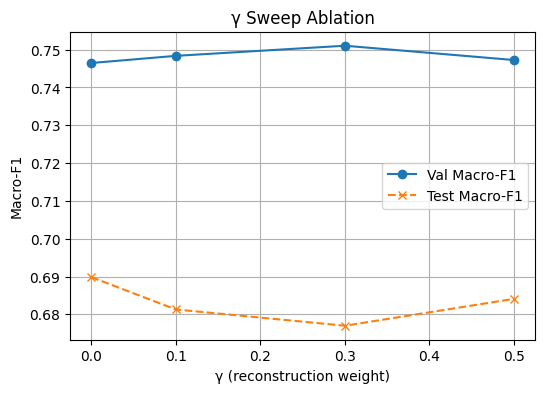

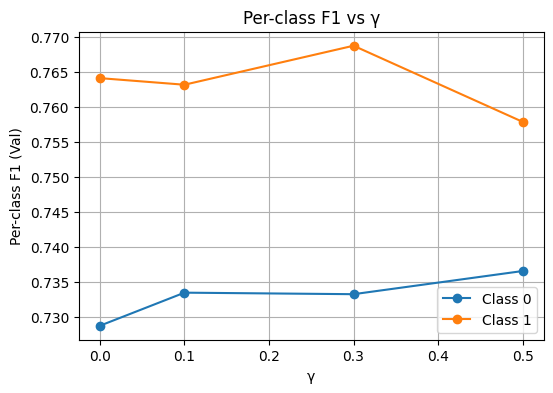

In [20]:
# ==== Run γ sweep ====
GAMMAS = [0.0, 0.1, 0.3, 0.5]
results = []

for g in GAMMAS:
    print(f"\n=== Running γ={g} ===")
    results.append(run_single_gamma(g))

res_df = pd.DataFrame(results)
out_dir = Path("runs"); out_dir.mkdir(exist_ok=True)
csv_path = out_dir / f"ablation_gamma_{timestamp()}.csv"
res_df.to_csv(csv_path, index=False)
print("Saved results ->", csv_path)

# ==== Plot Macro-F1 vs γ ====
plt.figure(figsize=(6,4))
plt.plot(res_df["gamma"], res_df["val_macro_f1"], marker="o", label="Val Macro-F1")
plt.plot(res_df["gamma"], res_df["test_macro_f1"], marker="x", linestyle="--", label="Test Macro-F1")
plt.xlabel("γ (reconstruction weight)")
plt.ylabel("Macro-F1")
plt.title("γ Sweep Ablation")
plt.legend()
plt.grid(True)
plt.show()

# ==== Per-class F1 (val) ====
plt.figure(figsize=(6,4))
expanded = []
for _, r in res_df.iterrows():
    per_f1 = json.loads(r["per_class_f1_val"])
    for i, f in enumerate(per_f1):
        expanded.append({"gamma": r["gamma"], "class": i, "f1": f})
per_df = pd.DataFrame(expanded)
for cls, sub in per_df.groupby("class"):
    plt.plot(sub["gamma"], sub["f1"], marker="o", label=f"Class {cls}")
plt.xlabel("γ")
plt.ylabel("Per-class F1 (Val)")
plt.title("Per-class F1 vs γ")
plt.legend()
plt.grid(True)
plt.show()


#### 3.5. Builder Test

In [27]:
m, trn, val, tst, opt, sch = build_vsae_from_cfg()
print("Model:", type(m).__name__)
print("Train/Val/Test loader sizes:", len(trn), len(val), len(tst))
print("Optimizer:", opt)
print("Scheduler:", sch)


Model: VariationalSiameseEncoder
Train/Val/Test loader sizes: 264 21 34
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0.01
)
Scheduler: None
